In [5]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py


#
from mpl_toolkits.mplot3d import Axes3D

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Step 0: Extract the point cloud data from the OBJ files
 - store as numpy arrays

In [2]:
# Getting the path to the Raw point clouds

OBJ_DIR = 'point_clouds/'

# Format is a tuple of (file path, file name).
OBJ_PATHS = [ [os.path.join(OBJ_DIR, f), f]
                    for f in os.listdir(OBJ_DIR) ]

OBJ_PATHS.remove(OBJ_PATHS[1]) # remove .DS Store file

# If we desire to treat the various objects within the OBJ as different spaces,
# we store it here.
new_per_object_collection = []

# If we desire to treat the entire OBJ as a space,
# we store it here.
new_per_space_collection = []

# This is to combine the objects within an OBJ to slightly larger objects. 
#Roughly 2.5m radius
combining_radius = 2.5

for path, filename in OBJ_PATHS:
    
    pointCloudFile = open(path)#'point_cloud.obj')('SpatialMesh.obj')#

    pointCloudLines = pointCloudFile.readlines()
    
    pointCollection = [] # object_number, vertices, vertex normals, polygons

    pointCollection_no_objects = [[],[],[]] 
    prev_length = 0
    vertices_length = 1
    
    for line in pointCloudLines:

        if line == '\n': continue

        line_items = line.split()

        if line_items[0] == 'o':
            object_item = line_items[1].split('.')
            object_number = int(object_item[-1])
            pointCollection.append([object_number, [], [], []])
            vertices_length += prev_length

            #print(object_number)

        if line_items[0] == 'v':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            if len(line_items)> 4:
                c = line_items[4]
                if float(c) > 0.85:
                    pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                    pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
            else:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z)])
            prev_length = len(pointCollection[object_number-1][1])


        if line_items[0] == 'vn':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            pointCollection[object_number-1][2].append([float(x),float(y),float(z)])
            pointCollection_no_objects[1].append([float(x),float(y),float(z)])

        if line_items[0] == 'f':
            p1 = int(line_items[1].split('//')[0])
            p2 = int(line_items[2].split('//')[0])
            p3 = int(line_items[3].split('//')[0])
            pointCollection[object_number-1][3].append([p1-vertices_length,
                                                        p2-vertices_length,
                                                        p3-vertices_length])
            pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

    pointCloudFile.close
    print(filename)
    #print(" Length of point collection",len(pointCollection[1][1]))
    print(" Total number of point collections",len(pointCollection))
    
    #Combining objects: 1. Getting centroids
    centroids = []

    for object_name, pointCloud, _vn, triangles in pointCollection:
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length
        normals = np.asarray(_vn)
        
        centroids.append([object_name,
              np.mean(pointCloud[:,0]), # x-axis
              np.mean(pointCloud[:,2]), # z-axis
             ])
        
    centroids = np.asarray(centroids)
    remaining_centroids = np.copy(centroids)
    
    combinedPointCollection = []
    count = 1
    
    while(remaining_centroids.size!=0):
        #print("  ",remaining_centroids[0,0],remaining_centroids.shape)
        #focusing on the first remaining collection, i.e. through its centroid
        collection = np.where(LA.norm(remaining_centroids[:,1:] - remaining_centroids[0,1:], axis = 1)<combining_radius)[0]
        
        #print("  ",collection)
        
        pointCloud = np.asarray(pointCollection[int(remaining_centroids[collection[0],0]-1)][1])
        normals = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][2])
        triangles = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][3])

        for index in collection[1:]:
            
            n_pointCloud = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][1])
            n_normals = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][2])
            n_triangles = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][3])+len(pointCloud)

            pointCloud = np.concatenate((pointCloud,n_pointCloud),0)
            normals = np.concatenate((normals,n_normals),0)
            triangles = np.concatenate((triangles,n_triangles),0)
        
        new_per_object_collection.append([
            filename+str(count),
            pointCloud,
            normals,
            triangles])
        
        combinedPointCollection.append([
            pointCloud,
            normals,
            triangles])
            
        count += 1
        remaining_centroids = np.delete(remaining_centroids,collection,axis=0)
        #print("   post",remaining_centroids.shape)
        
    print(" Resulting number =",len(combinedPointCollection))
#    new_per_object_collection.append([
#        filename,
#        combinedPointCollection
#    ])
    
    new_per_space_collection.append([
        filename,
        np.asarray(pointCollection_no_objects[0]),
        np.asarray(pointCollection_no_objects[1]),
        np.asarray(pointCollection_no_objects[2])
    ])

print(len(new_per_object_collection),"total objects.")
print(len(new_per_space_collection),"total spaces.")

Reception-Data61-L5.obj
 Total number of point collections 37
 Resulting number = 11
Driveway.obj
 Total number of point collections 51
 Resulting number = 11
Apartment.obj
 Total number of point collections 38
 Resulting number = 6
Workstations-Data61-L4.obj
 Total number of point collections 54
 Resulting number = 10
Kitchen-Data61-L4.obj
 Total number of point collections 105
 Resulting number = 18
HallWayToKitchen-Data61-L4.obj
 Total number of point collections 40
 Resulting number = 7
StairWell-Data61-L4.obj
 Total number of point collections 81
 Resulting number = 18
81 total objects.
7 total spaces.


In [3]:
# Combining the point position information with their normal vectors.

new_contiguous_point_collection = []

for object_name, pointCloud, vn, triangles in new_per_space_collection:
    new_contiguous_point_collection.append([
        object_name, 
        np.concatenate((pointCloud,vn),axis = 1),
        triangles
    ])
    
sample_index = np.random.choice(len(new_contiguous_point_collection))
print("Sample:",
      new_contiguous_point_collection[sample_index][0],
      new_contiguous_point_collection[sample_index][1].shape, # shape of the point cloud array
      new_contiguous_point_collection[sample_index][2].shape # shape of the triangle array
     )

"""
#Store the point clouds if desired
with open('point_collection/new_contiguous_point_collection.pickle','wb') as f: 
    pickle.dump(new_contiguous_point_collection,f)
""" 

Sample: Driveway.obj (56926, 6) (88560, 3)


"\n#Store the point clouds if desired\nwith open('point_collection/new_contiguous_point_collection.pickle','wb') as f: \n    pickle.dump(new_contiguous_point_collection,f)\n"

Driveway.obj (56926, 6) (88560, 3)


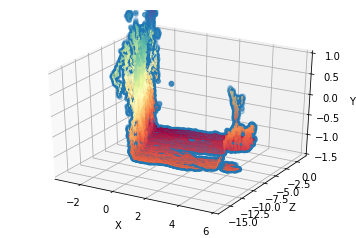

In [33]:
"""
fig=plt.figure()#figsize=(20, 14.5))

sample_name = new_contiguous_point_collection[sample_index][0]
sample_pointCloud = new_contiguous_point_collection[sample_index][1]
sample_triangles = new_contiguous_point_collection[sample_index][2]

print(sample_name,sample_pointCloud.shape,sample_triangles.shape)

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
#ax0.set_title('Dense Point Cloud')

X = sample_pointCloud[:,0]
Y = sample_pointCloud[:,1]
Z = sample_pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))

try:
    ax0.scatter(
        X,-Z,Y,
        alpha = 0.3
    )

    ax0.plot_trisurf(
        X, -Z, Y, 
        triangles=sample_triangles,
        cmap=plt.cm.Spectral
        #alpha = 0.5
    )

except Exception as ex:
    print(ex)
    pass

#plt.show()
"""

# Step 0.1 Getting the NNs for creating samples for testing

In [13]:
# For better testing, use bigger nn-range. We used 20,000.
nn_range = 300

for object_name, pointCloud, triangles in new_contiguous_point_collection:
    
    t0 = time.time()
    
    print(object_name, np.asarray(pointCloud).shape, np.asarray(triangles).shape)
    
    nbrs = NearestNeighbors(n_neighbors=min(nn_range, len(pointCloud)-1), algorithm='kd_tree').fit(pointCloud[:,:3])
    print("  Done in getting tree {:.3f} seconds.".format(time.time()-t0))

    distances, indices = nbrs.kneighbors(pointCloud[:,:3])

    print("  ",distances.shape,np.mean(np.max(distances,axis=0)), indices.shape)
    
    with h5py.File('hd5/{}_nn.h5'.format(object_name), 'w') as f:
        f.create_dataset('distances', data=distances)
        f.create_dataset('indices', data=indices)

    print("  Done in getting nn {:.3f} seconds.".format(time.time()-t0))

Reception-Data61-L5.obj (40491, 6) (67174, 3)
  Done in getting tree 0.029 seconds.
   (40491, 300) 2.4160527568802825 (40491, 300)
  Done in getting nn 3.349 seconds.
Driveway.obj (56926, 6) (88560, 3)
  Done in getting tree 0.075 seconds.
   (56926, 300) 1.3047040058362143 (56926, 300)
  Done in getting nn 4.582 seconds.
Apartment.obj (72859, 6) (126700, 3)
  Done in getting tree 0.084 seconds.
   (72859, 300) 1.2013160980989808 (72859, 300)
  Done in getting nn 4.811 seconds.
Workstations-Data61-L4.obj (73215, 6) (121972, 3)
  Done in getting tree 0.051 seconds.
   (73215, 300) 1.4038054840864285 (73215, 300)
  Done in getting nn 4.432 seconds.
Kitchen-Data61-L4.obj (102337, 6) (176558, 3)
  Done in getting tree 0.064 seconds.
   (102337, 300) 1.507763636171181 (102337, 300)
  Done in getting nn 6.194 seconds.
HallWayToKitchen-Data61-L4.obj (26398, 6) (44989, 3)
  Done in getting tree 0.025 seconds.
   (26398, 300) 1.6217560940912543 (26398, 300)
  Done in getting nn 1.533 seconds.


In [6]:
"""
    Extracting the NNs we got from the previous step and storing it as a 
    list that we can access to extract partial spaces.
"""
extracted_nns = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
    
    t0 = time.time()
    
    print(object_name, np.asarray(pointCloud).shape, np.asarray(triangles).shape)
    
    extracted_distances = []
    extracted_indices = []
    
    with h5py.File('hd5/{}_nn.h5'.format(object_name), 'r') as f:
        distances = f['distances']
        indices = f['indices']
        
        print("  Done extracting from file in {:.3f} seconds.".format(time.time()-t0))
        
        extracted_distances = np.copy(distances)
        extracted_indices = np.copy(indices)

    print("  ",extracted_distances.shape, extracted_indices.shape)
    
    print("  Done copying in {:.3f} seconds.".format(time.time()-t0))
    
    extracted_nns.append([
        object_name,
        extracted_distances,
        extracted_indices
    ])


Reception-Data61-L5.obj (40491, 6) (67174, 3)
  Done extracting from file in 0.001 seconds.
   (40491, 300) (40491, 300)
  Done copying in 0.274 seconds.
Driveway.obj (56926, 6) (88560, 3)
  Done extracting from file in 0.001 seconds.
   (56926, 300) (56926, 300)
  Done copying in 0.296 seconds.
Apartment.obj (72859, 6) (126700, 3)
  Done extracting from file in 0.001 seconds.
   (72859, 300) (72859, 300)
  Done copying in 0.377 seconds.
Workstations-Data61-L4.obj (73215, 6) (121972, 3)
  Done extracting from file in 0.001 seconds.
   (73215, 300) (73215, 300)
  Done copying in 0.344 seconds.
Kitchen-Data61-L4.obj (102337, 6) (176558, 3)
  Done extracting from file in 0.001 seconds.
   (102337, 300) (102337, 300)
  Done copying in 0.493 seconds.
HallWayToKitchen-Data61-L4.obj (26398, 6) (44989, 3)
  Done extracting from file in 0.001 seconds.
   (26398, 300) (26398, 300)
  Done copying in 0.085 seconds.
StairWell-Data61-L4.obj (77903, 6) (129848, 3)
  Done extracting from file in 0.001

In [7]:
def GetPartialPointCloudOptimizedNearby(
    pointCloud,
    triangles,
    radius = 1,
    vertex = [],
    verbose = False,
    extract = False,
    pointCloud_index = 0,
    nearby = False,
    nearby_threshold = 1.0
):

    t0 = time.time()
    triangle_indices = np.arange(len(triangles))
    
    if vertex == []:
        get_new_triangle = np.random.choice(triangle_indices)
    #rint("origin-triangle index",get_new_triangle,"(Remember, the triangle indices can be more than the point population.)")
        vertex = triangles[get_new_triangle,1]
        if verbose: print(" Computed origin-vertex",vertex)
    
    vertex = np.clip(vertex,0,len(pointCloud))

    if extract:
        nbrs = NearestNeighbors(n_neighbors=len(pointCloud)-1, algorithm='brute').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
    
    distances = extracted_nns[pointCloud_index][1]
    indices = extracted_nns[pointCloud_index][2]
    
    if nearby:    
        local_indexs =  indices[vertex,np.where(distances[vertex]<(radius*nearby_threshold))[0]]
        nearby_vertex = np.random.choice(local_indexs)
        vertex = nearby_vertex
        
    original_vertex = pointCloud[vertex]
    if verbose: print("   ",original_vertex[:3],vertex,pointCloud[vertex,:3])
    # makes sure that we don't get a point beyond the pC size
    # 1.b
    # list EVERYTHING, then update one-by-one

    #t1 = time.time()
    #print("  GetPartialPointCloud: Done getting nearest neighbors {:.3f} ".format(t1-t0))
    
    partial_pointcloud = []
    partial_triangles = []
    
    #while len(triangle_indices)>0:
    t0 = time.time()
    # Get a starting vertex
    

    # Get the acceptable neighbors of the chosen point
    acceptable_point_neighbors = indices[vertex,np.where(distances[vertex]<radius)[0]]
    depletable_triangles = np.copy(triangles)
    #print(len(acceptable_point_neighbors),"neighbors")
    acceptable_neighbor_distances = distances[vertex,np.where(distances[vertex]<radius)[0]]
    
    #t2 = time.time()
    #print("  GetPartialPointCloud: Done getting acceptable neighbors {:.3f} ".format(t2-t1))

    # While distance of points to be addded are less than 1,
    # get the indices of the connected items.
    prev_length = 0
    stopcount = 0

    # Get all triangles with the index in the neighbor list
    for v in acceptable_point_neighbors:    
        included_triangle_indices = np.concatenate((
            np.where(depletable_triangles[:,0]==v)[0],
            np.where(depletable_triangles[:,1]==v)[0],
            np.where(depletable_triangles[:,2]==v)[0]),0)

        local_triangles = depletable_triangles[np.unique(included_triangle_indices)]
        depletable_triangles = np.delete(depletable_triangles,np.unique(included_triangle_indices),0)

        if len(partial_triangles) > 0:
            partial_triangles = np.concatenate((partial_triangles,local_triangles),0)
            partial_triangles = np.asarray(partial_triangles)
        else:
            partial_triangles = local_triangles

    included_vertices = np.unique(partial_triangles.flatten('C'))
    index_list = []
    
    #t3 = time.time()
    #print("  GetPartialPointCloud: Done getting vertices {:.3f} ".format(t3 - t2))

    for in_vertex in included_vertices:
        if in_vertex in acceptable_point_neighbors:
            # before adding to the partial lists, check if in the acceptable neighbor list.

            partial_pointcloud.append(pointCloud[in_vertex])
            #depletable_neighbors = np.delete(depletable_neighbors,np.where(depletable_neighbors==in_vertex),0)
            index_list.append(in_vertex)
            np.place(partial_triangles,partial_triangles==in_vertex,len(partial_pointcloud)-1)
        else:
            # if not, remove associated triangles
            partial_triangles = np.delete(partial_triangles,np.unique(np.where(partial_triangles==in_vertex)[0]),0)

    #t4 = time.time()
    #print("  GetPartialPointCloud: Done getting triangles {:.3f} ".format(t4 - t3))
    
    partial_pointcloud = np.asarray(partial_pointcloud)
   
    return partial_pointcloud, partial_triangles, original_vertex, vertex


# Step 1: Compute the descriptors from the extracted point cloud

In [34]:
descriptors = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
            
    t0 = time.time()
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(
            pointCloud,
            down_resolution = 5,
            cylindrical_quantization = [4,5]
        )
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name,"in",time.time()-t0,"seconds.")
    print(" ",pointCloud.shape,triangles.shape)
    print(" ",t_keypoints.shape,t_descriptors.shape)
        
    descriptors.append([
        object_name,
        t_descriptors,
        t_keypoints,
        t_d_c
    ])
    
    with open('descriptors/new_complete_res5_4by5_descriptors.pickle','wb') as f:
        pickle.dump(descriptors,f)

Done with Reception-Data61-L5.obj in 81.43224906921387 seconds.
  (40491, 6) (67174, 3)
  (4023, 6) (4023, 20)
Done with Driveway.obj in 155.533793926239 seconds.
  (56926, 6) (88560, 3)
  (4872, 6) (4872, 20)
Done with Apartment.obj in 272.68058609962463 seconds.
  (72859, 6) (126700, 3)
  (5814, 6) (5814, 20)
Done with Workstations-Data61-L4.obj in 257.54437804222107 seconds.
  (73215, 6) (121972, 3)
  (7068, 6) (7068, 20)
Done with Kitchen-Data61-L4.obj in 376.28872084617615 seconds.
  (102337, 6) (176558, 3)
  (10063, 6) (10063, 20)
Done with HallWayToKitchen-Data61-L4.obj in 47.53719186782837 seconds.
  (26398, 6) (44989, 3)
  (3022, 6) (3022, 20)
Done with StairWell-Data61-L4.obj in 211.76498794555664 seconds.
  (77903, 6) (129848, 3)
  (8113, 6) (8113, 20)


# Step 2.1: Testing with Partial Spaces 

In [12]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = np.arange(0.5,1.1,0.25)

# We used 100 for our investigation
samples = 20

# 2.1.0 Creating a synthetic set of partial spaces

In [13]:
point_collection_indices = np.arange(len(new_contiguous_point_collection))

for radius in radius_range:
    
    partial_point_collection = []
    
    t0 = time.time()
    
    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        partial_pointcloud, partial_triangles, original_vertex, _v = GetPartialPointCloudOptimizedNearby(
            np.asarray(pointCloud),
            np.asarray(triangles),
            radius,
            pointCloud_index=random_object
        )
        
        partial_point_collection.append([
            [random_object, object_name, original_vertex],
            partial_pointcloud,
            partial_triangles            
        ])
        
        with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(partial_point_collection,f)
            
        if i % 10 == (samples-1)%10:
            print("Done with {} samples for radius = {:.2f} in {:.3f} seconds".format(i,radius,time.time() - t0))
            t0 = time.time()

Done with 9 samples for radius = 0.50 in 6.557 seconds
Done with 19 samples for radius = 0.50 in 5.727 seconds
Done with 9 samples for radius = 0.75 in 5.893 seconds
Done with 19 samples for radius = 0.75 in 6.389 seconds
Done with 9 samples for radius = 1.00 in 5.249 seconds
Done with 19 samples for radius = 1.00 in 6.257 seconds


# 2.1.2 Testing our partial samples: Raw spaces

In [14]:
"""
Extract descriptors
"""
try:    
    with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
        descriptors = pickle.load(f)
except:
    print("Extract descriptors first. See Step 1.")


for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        
    partial_scores = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(triangles)#-vertices_length

        t1 = time.time()

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                t_pointCloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 10 == (samples-1)%10:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RAW_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


 radius = 0.5: Done with 9 iterations. Time to match 8.164 seconds.
   Error Rate: 0.8888888888888888


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


 radius = 0.5: Done with 19 iterations. Time to match 8.185 seconds.
   Error Rate: 0.7894736842105261
0.5 Error Rate: 0.8000000000000003
 radius = 0.75: Done with 9 iterations. Time to match 10.428 seconds.
   Error Rate: 0.7777777777777777
 radius = 0.75: Done with 19 iterations. Time to match 8.712 seconds.
   Error Rate: 0.6842105263157894
0.75 Error Rate: 0.7000000000000002
 radius = 1.0: Done with 9 iterations. Time to match 8.780 seconds.
   Error Rate: 1.0
 radius = 1.0: Done with 19 iterations. Time to match 11.608 seconds.
   Error Rate: 0.7894736842105263
1.0 Error Rate: 0.8000000000000002


# 2.1.3 Testing our partial samples: RANSAC spaces

In [37]:
"""
Extract descriptors
"""
try:    
    with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
        descriptors = pickle.load(f)
except:
    print("Extract descriptors first. See Step 1.")

for radius in radius_range:
        
    t0 = time.time()
    
    with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'rb') as f:
        partial_point_collection = pickle.load(f)
        
    partial_scores = []
    partial_properties = []
    
    for obj_meta, partial_pointcloud, partial_triangles in partial_point_collection:
        
        # ROTATION
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

        # TRANSLATION
        t_pointCloud = np.asarray(rotated_pointCloud)
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
        t_triangles = np.asarray(triangles)#-vertices_length

        #if object_name % 13 == 0:
        #    print('{}: Processing iteration {} of object {}.'.format(radius,iteration,object_name))

        t1 = time.time()

        # GETTING GENERALIZATION
        gen_planes = getRansacPlanes(
            t_pointCloud
        )

        p_pointcloud, p_triangles = getGeneralizedPointCloud(
            planes=gen_planes, 
        )

        try:
            p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                p_pointcloud,
                down_resolution = 5,
                cylindrical_quantization = [4,5]
            )
        except Exception as ex:
            print("Error getting descriptors of",obj_meta)
            print("Error Message:",ex)
            
            continue

        # Resetting the diff_Ratio matrix
        diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
        diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
        diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

        #print(diff_ratios.shape)
        local_keypoint_matches = []

        for i_r, ref_descriptor in enumerate(descriptors):

            #o_, r_descriptors, r_keypoints, r_d_c
            r_descriptors = ref_descriptor[1]
            r_keypoints = ref_descriptor[2]

            matching_range = np.arange(r_descriptors.shape[1])

            #print('Processing iteration {} of object {}, comparing with {}.'.format(iteration,object_name,o_))

            # skip if descriptors are empty
    #        if len(p_descriptors) == 0:
    #            local_similarity_scores.append([0, # mean similarity
    #                                            len(p_descriptors), # number of partial descriptors
    #                                            len(r_descriptors), # number of reference descriptors
    #                                            0, # number of matches
    #                                           ])
                #local_bayesian_similarity.append(0)
    #            continue
            try:    
                f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                diff = diff/np.amax(diff) # max-normalization of differences
                diff_ratio = diff[:,0]/diff[:,1]
                diff_ratios[:,i_r] = diff_ratio
                diff_scores[:,i_r] = diff
                diff_indexs[:,i_r] = f_nearestneighbor
                
                # Taking note of the matched keypoints
                local_keypoint_matches.append([
                    obj_meta,
                    p_keypoints,
                    r_keypoints[f_nearestneighbor[:,0]]
                ])

            except Exception as ex:
                print(rotation,"Error Matching:",ex)

        # Accumulating the diff_ratio matrix for every partial (rotated) object
        partial_scores.append([
            obj_meta,
            np.asarray(diff_ratios),
            np.asarray(diff_indexs),
            np.asarray(diff_scores),
            local_keypoint_matches
        ])

        if len(partial_scores) % 33== 1:
            #print('Test')
            print(" radius = {}: Done with {} iterations. Time to match {:.3f} seconds.".format(
                radius,
                len(partial_scores),
                time.time()-t0)
                 )
            t0 = time.time()
        
            current_errors = NN_matcher(partial_scores)
            print("   Error Rate:",np.sum(current_errors[:,1]/len(partial_scores)))

    partial_errors = NN_matcher(partial_scores)
    print(radius,"Error Rate:",np.sum(partial_errors[:,1]/len(partial_scores)))
                                                                                
    with open('testing_results/partials/radius_{}_RANSAC_scores.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_scores,f)
                                              
    with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'wb') as f:
        pickle.dump(partial_errors,f)


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


 radius = 0.5: Done with 1 iterations. Time to match 2.637 seconds.
   Error Rate: 1.0


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


0.5 Error Rate: 0.9500000000000002
 radius = 0.75: Done with 1 iterations. Time to match 1.933 seconds.
   Error Rate: 1.0
0.75 Error Rate: 1.0000000000000002
 radius = 1.0: Done with 1 iterations. Time to match 1.720 seconds.
   Error Rate: 1.0
1.0 Error Rate: 0.9500000000000002


# 2.1.4 Results of partial spaces

/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: Mean of empty slice
/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


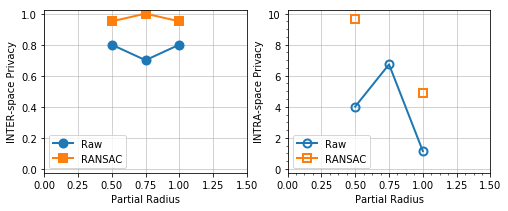

In [42]:
fig=plt.figure(figsize=(8, 3))

RawNN = []
RansacGeneralizedNN = []

RawNN_intra_errors = []
RansacGeneralizedNN_intra_errors = []

for radius in radius_range:
    
    try:
        with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RawNN.append([
            radius,
            np.mean(partial_errors[:,1]),
            np.std(partial_errors[:,1]),
        ])
        
        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RawNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
    try:
        with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RansacGeneralizedNN.append([
            radius,
            np.nanmean(partial_errors[:,1]),
            np.nanstd(partial_errors[:,1]),
        ])

        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RansacGeneralizedNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
RansacGeneralizedNN = np.asarray(RansacGeneralizedNN)
RawNN = np.asarray(RawNN)

RawNN_intra_errors = np.asarray(RawNN_intra_errors)
RansacGeneralizedNN_intra_errors = np.asarray(RansacGeneralizedNN_intra_errors)

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,1.5)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")
#ax1.set_yticklabels(fontsize = 16)
#ax1.set_xticklabels(fontsize = 16)

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    "-o",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "Raw"
)
ax1.plot(
    RansacGeneralizedNN[:,0],RansacGeneralizedNN[:,1],
    "-s",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax1.legend(loc = "lower left")

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,1.5)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

plt.minorticks_on()

ax2.plot(
    RawNN_intra_errors[:,0],
    RawNN_intra_errors[:,1], 
    linewidth = 2,
    marker = 'o',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "Raw"
)

ax2.plot(
    RansacGeneralizedNN_intra_errors[:,0],
    RansacGeneralizedNN_intra_errors[:,1], 
    linewidth = 2, 
    marker = 's',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax2.legend(loc = "lower left")

# Step 2.2 Testing with successively released partial spaces

In [50]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# We used 50 samples with further 100 successive releases for our investigation.
samples = 20
releases = 20

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

# 2.2.0 Creating a synthetic set of partial spaces

In [45]:
t0 = time.time()

for radius in radius_range:
        
    successive_point_collection = []

    t1 = time.time()

    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        #growing_p_pointcloud = []

        growing_point_collection = []

        for release in np.arange(releases):

            if release == 0:
                # For first release, as usual.
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius,
                    pointCloud_index=random_object,
                    #verbose = True
                )
            else:

                # For succeeding release, get a nearby point vertex everytime from the previous vertex
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius = radius,
                    vertex = previous_v_i,
                    pointCloud_index=random_object,
                    nearby = True,
                    nearby_threshold=2.0
                    #verbose = True
                )
                
                #print("  Previous vertex",previous_vertex[:3],previous_v_i,pointCloud[previous_v_i,:3])
                #print("  New vertex",original_vertex[:3],v_i,pointCloud[v_i,:3])                
                
                if LA.norm(original_vertex[:3] - previous_vertex[:3]) >= 2.0*radius:
                    print("  Release: {} Warning: The distance of the succeeding vertices is {:.2f}"
                          .format(release,LA.norm(original_vertex[:3] - previous_vertex[:3]))
                         )
                    
            previous_v_i = v_i
            previous_vertex = original_vertex

            growing_point_collection.append([
                [random_object, object_name, original_vertex],
                partial_pointcloud,
                partial_triangles            
            ])

            if (release % 10 == (releases-1)%10) and (i % 10 == (samples-1)%10):
                print("  Done with {} releases of iteration {} for radius = {:.2f} in {:.3f} seconds"
                      .format(release,i,radius,time.time() - t1))
                t1 = time.time()

        successive_point_collection.append([
            [random_object, object_name],
            growing_point_collection
        ])

        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_point_collection,f)

    print(" Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()


/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


  Done with 9 releases of iteration 9 for radius = 0.50 in 123.798 seconds
  Done with 19 releases of iteration 9 for radius = 0.50 in 3.256 seconds
  Done with 9 releases of iteration 19 for radius = 0.50 in 112.347 seconds
  Done with 19 releases of iteration 19 for radius = 0.50 in 6.852 seconds
 Done with radius = 0.50 in 246.279 seconds
  Done with 9 releases of iteration 9 for radius = 0.75 in 110.877 seconds
  Done with 19 releases of iteration 9 for radius = 0.75 in 2.701 seconds
  Done with 9 releases of iteration 19 for radius = 0.75 in 144.971 seconds
  Done with 19 releases of iteration 19 for radius = 0.75 in 10.667 seconds
 Done with radius = 0.75 in 269.243 seconds
  Done with 9 releases of iteration 9 for radius = 1.00 in 101.996 seconds
  Done with 19 releases of iteration 9 for radius = 1.00 in 8.635 seconds
  Done with 9 releases of iteration 19 for radius = 1.00 in 131.849 seconds
  Done with 19 releases of iteration 19 for radius = 1.00 in 5.347 seconds
 Done with 

# 2.2.1 Testing the successive case: RAW and RANSAC

In [51]:
for radius in radius_range:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
    except:
        pass
    
    successive_scores = []
    successive_errors = []
    
    g_successive_scores = []
    g_successive_errors = []

    for obj_, growing_point_collection in successive_point_collection:
        
        iteration_scores = []
        
        g_iteration_scores = []
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        growing_point_cloud = []
        growing_p_point_cloud = []
        growing_p_triangles = []
        
        release_count = 0
    
        for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
            #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

            rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

            # TRANSLATION
            t_pointCloud = np.asarray(rotated_pointCloud)
            t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
            t_triangles = np.asarray(partial_triangles)#-vertices_length
            
            #Regular Accumulation
            if len(growing_point_cloud) == 0:
                growing_point_cloud = t_pointCloud

            else:
                growing_point_cloud = np.concatenate(
                    (growing_point_cloud,t_pointCloud),
                    axis=0
                )
                
            #RANSAC generalizations
            if len(growing_p_point_cloud) == 0:
                gen_planes = getLOCALIZEDRansacPlanes(
                    pointCloud = t_pointCloud,
                    original_vertex = obj_meta[-1]
                )
            else:
                gen_planes = updatePlanesWithSubsumption(
                    new_pointCloud=t_pointCloud,
                    existing_pointCloud=growing_p_point_cloud,
                    planes_to_find = max(min(release_count,50),30),
                    #verbose=True
                )
            
            if len(gen_planes) == 0:
                print("No gen planes after release",release_count,growing_point_cloud.shape)
                continue

            try:
                updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                    planes = gen_planes,
                    triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                    #verbose = True
                )
                growing_p_point_cloud = updated_point_cloud
                growing_p_triangles = updated_triangles
                
                #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
            except Exception as ex:
                print("Error getting updated point cloud in release",release_count+1)
                print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                #print(ex)
                continue
                
            if len(growing_p_point_cloud) == 0:
                continue
                
            release_count += 1
            
            if release_count % skip != 1: # skip if not 5th accumulated release
                continue
                
            #Regular Processing
            growing_point_cloud = np.unique(growing_point_cloud,axis=0)
            
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {}: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(iteration_scores),
                    release_count,
                    len(successive_scores),
                    time.time()-t0,
                    growing_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(iteration_scores)
                print("   Error Rate:",np.sum(current_errors[:,1]/len(iteration_scores)))
            
            #RANSAC Processing         
            try:
                p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                    growing_p_point_cloud,
                    down_resolution = 5,
                    cylindrical_quantization = [4,5]
                )
            except:
                p_descriptors = []
                p_keypoints = []
                
                print("Error getting descriptors at release",release_count,"; using next release as this release.")
                
                #release_count -= 1

                continue

            # Resetting the diff_Ratio matrix
            diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
            diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
            diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

            local_keypoint_matches = []

            for i_r, ref_descriptor in enumerate(descriptors):

                #o_, r_descriptors, r_keypoints, r_d_c
                r_descriptors = ref_descriptor[1]
                r_keypoints = ref_descriptor[2]

                matching_range = np.arange(r_descriptors.shape[1])

                try:    
                    f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                    diff = diff/np.amax(diff) # max-normalization of differences
                    diff_ratio = diff[:,0]/diff[:,1]
                    diff_ratios[:,i_r] = diff_ratio
                    diff_scores[:,i_r] = diff
                    diff_indexs[:,i_r] = f_nearestneighbor

                    # Taking note of the matched keypoints
                    local_keypoint_matches.append([
                        obj_meta,
                        p_keypoints,
                        r_keypoints[f_nearestneighbor[:,0]]
                    ])

                except Exception as ex:
                    print(rotation,"Error Matching:",ex)

            # Accumulating the diff_ratio matrix for every partial (rotated) object
            g_iteration_scores.append([
                obj_meta,
                diff_ratios,
                diff_indexs,
                diff_scores,
                local_keypoint_matches
            ])

            if release_count % 2 == 0:
                #print('Test')
                print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                    radius,
                    len(g_iteration_scores),
                    release_count,
                    len(g_successive_scores),
                    time.time()-t0,
                    growing_p_point_cloud.shape
                )
                     )
                t0 = time.time()

                current_errors = NN_matcher(g_iteration_scores)
                print("   G_Error Rate:",np.sum(current_errors[:,1]/len(g_iteration_scores)))

        iteration_errors = NN_matcher(iteration_scores)

        g_iteration_errors = NN_matcher(g_iteration_scores)

        if len(successive_scores) % 5 == (samples-1)%5 :
            print(radius,len(successive_scores),"Error Rate:",np.sum(iteration_errors[:,1]/len(iteration_scores)))
            print(radius,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))

        successive_scores.append([
            obj_,
            iteration_scores
        ])
        
        successive_errors.append([
            obj_,
            iteration_errors
        ])
        
        g_successive_scores.append([
            obj_,
            g_iteration_scores
        ])
        
        g_successive_errors.append([
            obj_,
            g_iteration_errors
        ])
    
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_scores,f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_errors,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)

/Users/deg032/Projects/3D-spatial-privacy/info3d.py:889: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(firstPlane[1],point[3:])/(LA.norm(firstPlane[1])*LA.norm(point[3:]))) > (1-20*threshold):


  radius = 0.5: Done with 2 releases (4) (0 iteration/s). Time to match 13.895 seconds. ((1116, 6))
   Error Rate: 0.0


/Users/deg032/Projects/3D-spatial-privacy/nn_matchers.py:492: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


  radius = 0.5 [G]: Done with 2 releases (4) (0 iteration/s). Time to match 2.243 seconds. ((605, 6))
   G_Error Rate: 1.0


/Users/deg032/Projects/3D-spatial-privacy/info3d.py:1011: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:808: RuntimeWarning: invalid value encountered in double_scalars
  if abs(np.dot(testPlane[1],point[3:])/(LA.norm(testPlane[1])*LA.norm(point[3:]))) > max(0,(1-20*threshold)):
/Users/deg032/Projects/3D-spatial-privacy/info3d.py:804: RuntimeWarning: invalid value encountered in double_scalars
  if abs((np.dot(testPlane[1],point[:3])+d)*1.0/LA.norm(testPlane[1],ord = 2)) < threshold:


  radius = 0.5: Done with 2 releases (4) (1 iteration/s). Time to match 19.206 seconds. ((726, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 2 releases (4) (1 iteration/s). Time to match 1.889 seconds. ((626, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 4 releases (10) (1 iteration/s). Time to match 14.937 seconds. ((959, 6))
   Error Rate: 0.5
  radius = 0.5 [G]: Done with 4 releases (10) (1 iteration/s). Time to match 3.318 seconds. ((1024, 6))
   G_Error Rate: 1.0
  radius = 0.5: Done with 6 releases (16) (1 iteration/s). Time to match 21.931 seconds. ((1308, 6))
   Error Rate: 0.3333333333333333
  radius = 0.5 [G]: Done with 6 releases (16) (1 iteration/s). Time to match 6.162 seconds. ((2177, 6))
   G_Error Rate: 0.9999999999999999
  radius = 0.5: Done with 2 releases (4) (2 iteration/s). Time to match 22.874 seconds. ((996, 6))
   Error Rate: 1.0
  radius = 0.5 [G]: Done with 2 releases (4) (2 iteration/s). Time to match 2.078 seconds. ((536, 6))
   G_Error Rate: 1.0

IndexError: too many indices for array

In [ ]:
planes = np.arange(1,30,2)

for radius in radius_range:
        
    t0 = time.time()
    
    try:
        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'rb') as f:
            successive_point_collection = pickle.load(f)
    except:
        pass
    
    g_successive_scores = []
    g_successive_errors = []
    
    for obj_, growing_point_collection in successive_point_collection:
        
        # ROTATION param
        random_theta =  (2*np.pi)*np.random.random()# from [0, 2pi)
        random_axis = np.random.choice(np.arange(0,3))
        
        # TRANSLATION param
        random_tx_axis = np.random.choice(np.arange(0,3))
        random_translation = np.random.random()
        
        per_plane_successive_scores = []
        per_plane_successive_errors = []
        
        latest_plane = 0
        
        for plane_number in planes:
            
            print(" {} planes, ({} Done)".format(plane_number,len(per_plane_successive_scores)))
        
            g_iteration_scores = []

            growing_point_cloud = []
            growing_p_point_cloud = []
            growing_p_triangles = []

            release_count = 0
            
            for obj_meta, partial_pointcloud, partial_triangles in growing_point_collection:
                #i_obj, released_growing_point_collection in enumerate(growing_point_collection):

                # ROTATION
                rotated_pointCloud = rotatePointCloud(partial_pointcloud, random_theta, random_axis)

                # TRANSLATION
                t_pointCloud = np.asarray(rotated_pointCloud)
                t_pointCloud[:,random_tx_axis] = t_pointCloud[:,random_tx_axis] + random_translation
                t_triangles = np.asarray(partial_triangles)#-vertices_length

                #RANSAC generalizations
                try:
                    if len(growing_p_point_cloud) == 0:
                        gen_planes = getLOCALIZEDRansacPlanes(
                            pointCloud = t_pointCloud,#np.where(hPointConnectivity < 5)[0],axis = 0),
                            original_vertex = obj_meta[-1],
                            planes_to_find=plane_number
                            #verbose=True
                            #threshold = threshold # the point-plane distance threshold
                        )
                    else:
                        gen_planes = updatePlanesWithSubsumption(
                            new_pointCloud=t_pointCloud,
                            existing_pointCloud=growing_p_point_cloud,
                            planes_to_find = plane_number
                            #verbose=True
                        )
                except:
                    print("Error getting planes",release_count,growing_point_cloud.shape)
                    continue

                if len(gen_planes) == 0:
                    print("No gen planes after release",release_count,growing_point_cloud.shape)
                    continue

                try:
                    updated_point_cloud, updated_triangles = getGeneralizedPointCloud(
                        planes = gen_planes,
                        triangle_area_threshold = 0.2,#2.0*np.amax(getTriangleAreas(partial_pointCloud, partial_triangles))
                        #verbose = True
                    )
                    growing_p_point_cloud = updated_point_cloud
                    growing_p_triangles = updated_triangles

                    #print(" Successful:",release_count,len(growing_p_point_cloud), len(growing_p_triangles),partial_pointCloud.shape)
                except Exception as ex:
                    print("Error getting updated point cloud in release",release_count+1)
                    print(" ",growing_p_point_cloud.shape, growing_p_triangles.shape,partial_pointCloud.shape)
                    #print(ex)
                    continue

                if len(growing_p_point_cloud) == 0:
                    continue

                release_count += 1

                if release_count % skip != 1: # skip if not 5th accumulated release
                    continue

                #RANSAC Processing         
                try:
                    p_descriptors, p_keypoints, p_d_c = getSpinImageDescriptors(
                        growing_p_point_cloud,
                        down_resolution = 5,
                        cylindrical_quantization = [4,5]
                    )
                except:
                    p_descriptors = []
                    p_keypoints = []

                    print("Error getting descriptors at release",release_count,"; using next release as this release.")

                    #release_count -= 1

                    continue

                # Resetting the diff_Ratio matrix
                diff_scores = np.ones((p_descriptors.shape[0],len(descriptors),2))
                diff_ratios = np.ones((p_descriptors.shape[0],len(descriptors)))
                diff_indexs = np.ones((p_descriptors.shape[0],len(descriptors),2))

                local_keypoint_matches = []

                for i_r, ref_descriptor in enumerate(reference_descriptors):

                    #o_, r_descriptors, r_keypoints, r_d_c
                    r_descriptors = ref_descriptor[1]
                    r_keypoints = ref_descriptor[2]

                    matching_range = np.arange(r_descriptors.shape[1])

                    #print('Processing iteration {} of object {}, comparing with {}.'.format(iteration,object_name,o_))

                    # skip if descriptors are empty
            #        if len(p_descriptors) == 0:
            #            local_similarity_scores.append([0, # mean similarity
            #                                            len(p_descriptors), # number of partial descriptors
            #                                            len(r_descriptors), # number of reference descriptors
            #                                            0, # number of matches
            #                                           ])
                        #local_bayesian_similarity.append(0)
            #            continue
                    try:    
                        f_nearestneighbor, diff = getMatches(p_descriptors,r_descriptors,2,range_to_match=matching_range)
                        diff = diff/np.amax(diff) # max-normalization of differences
                        diff_ratio = diff[:,0]/diff[:,1]
                        diff_ratios[:,i_r] = diff_ratio
                        diff_scores[:,i_r] = diff
                        diff_indexs[:,i_r] = f_nearestneighbor

                        # Taking note of the matched keypoints
                        local_keypoint_matches.append([
                            obj_meta,
                            p_keypoints,
                            r_keypoints[f_nearestneighbor[:,0]]
                        ])

                    except Exception as ex:
                        print(rotation,"Error Matching:",ex)

                # Accumulating the diff_ratio matrix for every partial (rotated) object
                g_iteration_scores.append([
                    obj_meta,
                    diff_ratios,
                    diff_indexs,
                    diff_scores,
                    local_keypoint_matches
                ])

        # --- !
                if release_count % 2 == 0:
                    #print('Test')
                    print("  radius = {} [G]: Done with {} releases ({}) ({} samples). Time to match {:.3f} seconds. ({})".format(
                        radius,
                        len(g_iteration_scores),
                        release_count,
                        len(g_successive_scores),
                        time.time()-t0,
                        growing_p_point_cloud.shape
                    )
                         )
                    t0 = time.time()

                    current_errors = NN_matcher(g_iteration_scores)
                    print("   ({} actual planes) G_Error Rate: {}".format(
                        len(gen_planes),
                        np.sum(current_errors[:,1]/len(g_iteration_scores))
                    ))

                g_iteration_errors = NN_matcher(g_iteration_scores)
            try:
                print(radius,plane_number,len(g_successive_scores),"G_Error Rate:",np.sum(g_iteration_errors[:,1]/len(g_iteration_scores)))
            except:
                pass

            per_plane_successive_scores.append([
                plane_number,
                g_iteration_scores
            ])

            per_plane_successive_errors.append([
                plane_number,
                g_iteration_errors
            ])

        g_successive_scores.append([
            obj_,
            per_plane_successive_scores
        ])

        g_successive_errors.append([
            obj_,
            per_plane_successive_errors
        ])
        
        if len(successive_scores) % 5 == (samples-1)%5 :
            print("Radius = {}, {} objects done".format(radius,len(g_successive_scores)))

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_scores.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_scores,f)

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_errors.pickle'.format(radius), 'wb') as f:
            pickle.dump(g_successive_errors,f)
                